# Final Project: Advanced Machine Learning
    Randi Brennan - 5/2/2021
    Summary: The goal of this nerual network is to use a pre-created CNN network and adapt the code to classify images based on a live/current data source. In this example I have taken images from two different sources online and merged them into one folder. The neural network will then decide if an x-ray is normal, covid or pneumonia.
        

In [161]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import RMSprop
import itertools

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import math
import datetime
import keras
import itertools
import time
from keras import optimizers
from keras import applications
%matplotlib inline
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing import image
from keras.models import Sequential

## Step 1: 
Import the file directory paths into Jupyter and set variable names. In this section we can also see a preview of the images that are contained within the files.

In [65]:
#https://github.com/tirthajyoti/Deep-learning-with-Python/blob/master/Notebooks/Keras_flow_from_directory.ipynb

train_COVID = os.path.join('/Users/randibrennan/Desktop/chest_xray/train/COVID')

In [66]:
train_NORMAL = os.path.join('/Users/randibrennan/Desktop/chest_xray/train/NORMAL')

In [67]:
train_PNEUMONIA = os.path.join('/Users/randibrennan/Desktop/chest_xray/train/PNEUMONIA')

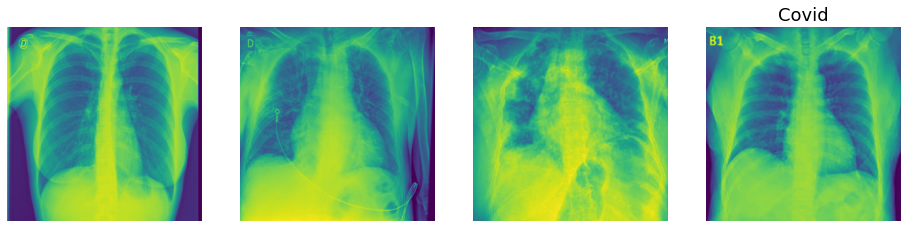

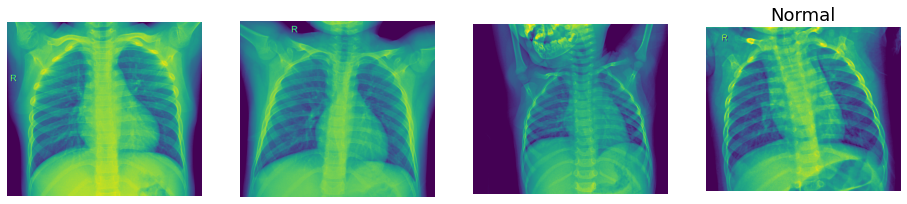

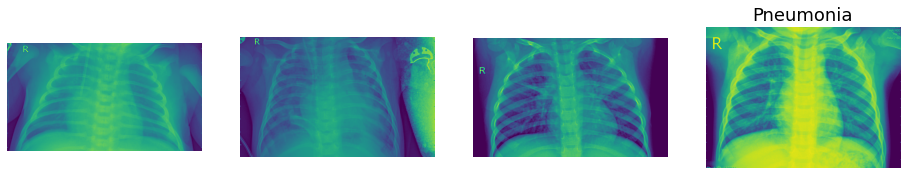

In [70]:
#This code allows for images to be joined one after another and display a 4 picture sample.

nrows = 2
ncols = 4

pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_COVID_pix = [os.path.join(train_COVID,fname)
                 for fname in train_COVID_names[pic_index-4:pic_index]]

next_NORMAL_pix = [os.path.join(train_NORMAL,fname)
                 for fname in train_NORMAL_names[pic_index-4:pic_index]]

next_PNEUMONIA_pix = [os.path.join(train_PNEUMONIA,fname)
                 for fname in train_PNEUMONIA_names[pic_index-4:pic_index]]

print()
for i, img_path in enumerate(next_COVID_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.title("Covid", size=18)    
plt.show()

print()
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
for i, img_path in enumerate(next_NORMAL_pix):
    sp= plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    
    img = mpimg.imread(img_path)
    plt.imshow(img)
    
plt.title("Normal", size=18)
plt.show()

print()
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
for i, img_path in enumerate(next_PNEUMONIA_pix):
    sp= plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.title("Pneumonia", size=18)    
plt.show()

In [69]:
#This gives a sample of the image names that are found in the dataset

train_COVID_names = os.listdir(train_COVID)
print(train_COVID_names[:5])

train_NORMAL_names = os.listdir(train_NORMAL)
print(train_NORMAL_names[:5])

train_PNEUMONIA_names = os.listdir(train_PNEUMONIA)
print(train_PNEUMONIA_names[:5])

['COVID-1175.png', 'COVID-1613.png', 'COVID-948.png', 'COVID-790.png', 'COVID-3004.png']
['NORMAL2-IM-0927-0001.jpeg', 'NORMAL2-IM-1056-0001.jpeg', 'IM-0427-0001.jpeg', 'NORMAL2-IM-1260-0001.jpeg', 'IM-0656-0001-0001.jpeg']
['person63_bacteria_306.jpeg', 'person1438_bacteria_3721.jpeg', 'person755_bacteria_2659.jpeg', 'person478_virus_975.jpeg', 'person661_bacteria_2553.jpeg']


In [2]:
#Set image paramaters
img_width, img_height = 224, 224

In [3]:
#create bottleneck file for preprocessing data. This helps with model efficency later.
top_model_weights_path = 'bottleneck_fc_model.h5'

In [4]:
# This is the beginning of the model build. Here we are setting the top level directories
# for the algorithm to process from.
train_dir = '/Users/randibrennan/Desktop/chest_xray/train'
val_dir = '/Users/randibrennan/Desktop/chest_xray/val'
test_dir = '/Users/randibrennan/Desktop/chest_xray/test'

## Step 2:
After locating/importing the directories that contiain the images, they are now run through and transformed into Numpy arrays. This process uses the VGG16(pre-created neural network). The code marks the start and end time and shows total time by subtracting end from start. It also displays the number of records and classes found.

In [ ]:
#Choose batch size
batch_size = 128

In [ ]:
#Prepare to rescale images to standardize and help with efficency
vgg16 = applications.VGG16(include_top=False, weights='imagenet')

datagen = ImageDataGenerator(rescale=1./255)

In [7]:
#Set date/time feature to show how long each process takes. This code is run for each of the three
#"training", "test" and "validation"
#Search directory, number images and datagen creates bottleneck
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

Found 8434 images belonging to 3 classes.


In [9]:
#Create bottleneck file that will store images as npy array. This is run for all three categories as well.
nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = vgg16.predict_generator(generator,
                                                   predict_size_train)

np.save('bottleneck_features_train.npy', bottleneck_features_train)
end = datetime.datetime.now()
elapsed = end-start
print('Time: ', elapsed)

Time:  0:38:55.285440


In [10]:
#Process test_dir same as above
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

Found 1014 images belonging to 3 classes.


In [11]:
#Create test bottleneck
nb_test_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_test = int(math.ceil(nb_test_samples / batch_size))

bottleneck_features_test = vgg16.predict_generator(generator,
                                                   predict_size_test)

np.save('bottleneck_features_test.npy', bottleneck_features_test)
end = datetime.datetime.now()
elapsed = end-start
print('Time: ', elapsed)

Time:  0:02:27.269984


In [15]:
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

Found 24 images belonging to 3 classes.


In [16]:
nb_val_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_val = int(math.ceil(nb_val_samples / batch_size))

bottleneck_features_val = vgg16.predict_generator(generator,
                                                   predict_size_val)

np.save('bottleneck_features_val.npy', bottleneck_features_val)
end = datetime.datetime.now()
elapsed = end-start
print('Time: ', elapsed)

Time:  0:00:03.410927


In [17]:
#Create training bottlneck.npy file. 
generator_top = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

nb_train_samples = len(generator_top.filenames)
num_classes = len(generator_top.class_indices)

train_data = np.load('bottleneck_features_train.npy')

train_lables = generator_top.classes

train_lables = to_categorical(train_lables, num_classes=num_classes)

Found 8434 images belonging to 3 classes.


In [18]:
generator_top = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

nb_test_samples = len(generator_top.filenames)
num_classes = len(generator_top.class_indices)

test_data = np.load('bottleneck_features_test.npy')

test_lables = generator_top.classes

test_lables = to_categorical(test_lables, num_classes=num_classes)

Found 1014 images belonging to 3 classes.


In [19]:
generator_top = datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

nb_val_samples = len(generator_top.filenames)
num_classes = len(generator_top.class_indices)

val_data = np.load('bottleneck_features_val.npy')

val_lables = generator_top.classes

val_lables = to_categorical(val_lables, num_classes=num_classes)

Found 24 images belonging to 3 classes.


## Step 3: 
This is where we build the model. This model uses Leaky ReLU activation function in the layers as well as softmax.

In [94]:
#Choose batch size
batch_size = 100

In [120]:
#Build model with dropout and using LeakyReLU. Final layer will use softmax activation.
#Attempted with other activation types and softmax works the best for this data.
start = datetime.datetime.now()
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.5))
model.add(Dense(128, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.3))
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

history = model.fit(train_data, train_lables,
                   epochs = 8,
                   batch_size=batch_size,
                   validation_data=(val_data, val_lables))

model.save_weights(top_model_weights_path)

(eval_loss, eval_accuracy) = model.evaluate(
    val_data, val_lables, batch_size=batch_size,
    verbose=1)


print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))
end = datetime.datetime.now()
elapsed = end-start
print('Time: ', elapsed)

Epoch 1/8
85/85 [==============================] - 2s 20ms/step - loss: 0.6984 - acc: 0.7015 - val_loss: 0.3004 - val_acc: 0.8333
Epoch 2/8
85/85 [==============================] - 2s 18ms/step - loss: 0.2184 - acc: 0.9279 - val_loss: 0.1943 - val_acc: 0.9583
Epoch 3/8
85/85 [==============================] - 2s 19ms/step - loss: 0.1402 - acc: 0.9480 - val_loss: 0.5546 - val_acc: 0.7917
Epoch 4/8
85/85 [==============================] - 2s 19ms/step - loss: 0.1141 - acc: 0.9613 - val_loss: 0.2596 - val_acc: 0.9167
Epoch 5/8
85/85 [==============================] - 2s 19ms/step - loss: 0.0963 - acc: 0.9675 - val_loss: 0.3566 - val_acc: 0.8333
Epoch 6/8
85/85 [==============================] - 2s 19ms/step - loss: 0.0763 - acc: 0.9757 - val_loss: 0.3807 - val_acc: 0.8333
Epoch 7/8
85/85 [==============================] - 2s 19ms/step - loss: 0.0672 - acc: 0.9771 - val_loss: 0.2034 - val_acc: 0.9167
Epoch 8/8
1/1 [==============================] - 0s 15ms/step - loss: 0.1984 - acc: 0.9583

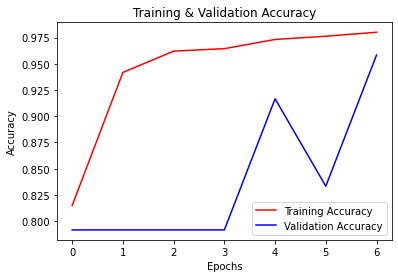

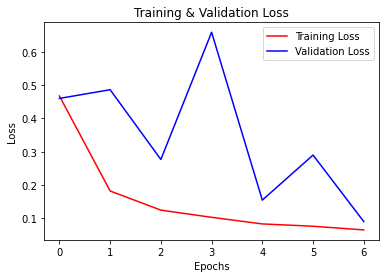

In [118]:
#This takes the above data and creates two graphs of the validation accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [107]:
#evaluate the overall performance
model.evaluate(test_data, test_lables)

32/32 [==============================] - 0s 4ms/step - loss: 0.3814 - acc: 0.8945


[0.3814004063606262, 0.8944773077964783]

In [130]:
#matrix results of accuracy
preds = np.round(model.predict(test_data),0)
print('rounded test_labels', preds)

rounded test_labels [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [219]:
#Display a classification report of results
classes = ['COVID', 'NORMAL', 'PNEUMONIA']
classification_metrics = metrics.classification_report(test_lables, preds,
                                                      target_names=classes)
print(classification_metrics)

              precision    recall  f1-score   support

       COVID       0.97      0.99      0.98       390
      NORMAL       0.96      0.43      0.60       234
   PNEUMONIA       0.77      0.99      0.86       390

   micro avg       0.87      0.86      0.87      1014
   macro avg       0.90      0.80      0.81      1014
weighted avg       0.89      0.86      0.85      1014
 samples avg       0.86      0.86      0.86      1014

